In [9]:
import pandas as pd
import numpy as np
import pickle

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

In [12]:
# Create a function to read data and prepare everything
def read_dataframe(filename):
    # Read Data
    df = pd.read_parquet(filename)
    
    # Create new duration field in minutes
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # Select the data which belongs to 98%/99% percentile
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    df = df[(df.trip_distance >= 0) & (df.trip_distance <= 24)]
    
    # Define Categorical
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
dv = DictVectorizer()
categorical = ['PU_DO']
numerical = ['trip_distance']

# Create train dictonary and vectorize it
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# Create validation dictonary and vectorize it
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
# Define target
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
#Train the model and predict
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

# Look into 
mean_squared_error(y_val, y_pred, squared=False)

6.6989660849932005

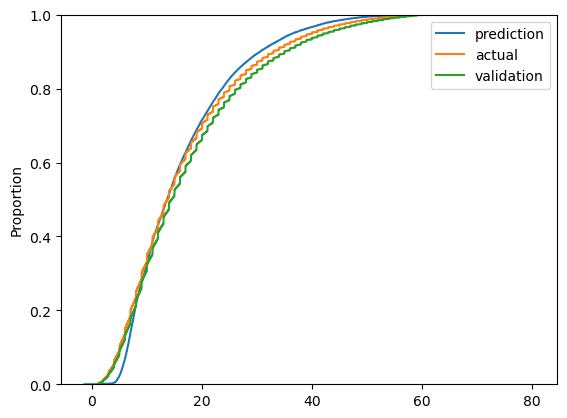

In [24]:
#sns.distplot(y_pred, label='prediction')
#sns.distplot(y_train, label='actual')
#sns.distplot(y_val, label='validation')

#sns.histplot(y_pred, bins=50, kde=True, label='prediction')
#sns.histplot(y_train, bins=50, kde=True, label='actual')
#sns.histplot(y_val, bins=50, kde=True, label='validation')

#sns.kdeplot(y_pred, label='prediction')
#sns.kdeplot(y_train, label='actual')
#sns.kdeplot(y_val, label='validation')

sns.ecdfplot(y_pred, label='prediction')
sns.ecdfplot(y_train, label='actual')
sns.ecdfplot(y_val, label='validation')

plt.legend()

In [ ]:
# Export the model built before
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)